In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import networkx as nx
import numpy as np

# ---------- 1. Grafo y labels ----------
def make_n_partite_graph(n_parts=2, n_per_part=50, p_edge=0.1, seed=0):
    """
    Genera un grafo n-partito con n_parts partes, cada parte con n_per_part nodos.
    - Solo se permiten aristas entre distintas partes (no intra-parte).
    - p_edge: probabilidad de arista entre pares de nodos de partes distintas.
    Devuelve (G, edges, labels) donde edges es un array (m,2) de int64 y labels es np.array de tamaño n_nodes.
    """
    rng = np.random.RandomState(seed)
    G = nx.Graph()
    total_nodes = n_parts * n_per_part

    # Añadir nodos y asignarles parte/label:
    for part in range(n_parts):
        nodes = list(range(part * n_per_part, (part + 1) * n_per_part))
        G.add_nodes_from(nodes, part=part, label=part)

    # Añadir aristas aleatorias entre partes:
    for i in range(n_parts):
        start_i = i * n_per_part
        for j in range(i + 1, n_parts):
            start_j = j * n_per_part
            for a in range(start_i, start_i + n_per_part):
                for b in range(start_j, start_j + n_per_part):
                    if rng.rand() < p_edge:
                        G.add_edge(a, b)
    
    # Forzar conectividad uniendo componentes si hace falta
    if not nx.is_connected(G):
        comps = list(nx.connected_components(G))
        for k in range(len(comps) - 1):
            u = next(iter(comps[k]))
            v = next(iter(comps[k + 1]))
            G.add_edge(u, v)

    labels = np.array([G.nodes[i]['label'] for i in range(total_nodes)])
    edges = np.array(list(G.edges()), dtype=np.int64)
    return G, edges, labels

# ---------- 2. Features Gaussianos solapados ----------
def make_gaussian_features(labels, mu=1.0, sigma=1.0, seed=0):
    rng = np.random.RandomState(seed)
    n = len(labels)
    fdim = 2  # 2D para poder visualizar
    X = np.zeros((n, fdim), dtype=np.float32)
    
    for i, y in enumerate(labels):
        mean = np.array([mu,0])
        X[i] = rng.normal(loc=mean, scale=sigma, size=(fdim,))
    return X.astype(np.float32)

# Ejemplo de uso:
G, edges, labels = make_n_partite_graph(n_parts=2, n_per_part=100, p_edge=0.05, seed=0)
X0 = make_gaussian_features(labels, mu=1.0, sigma=1.5, seed=0)

X0 = torch.from_numpy(X0)
y  = torch.from_numpy(labels)
edges_torch = torch.from_numpy(edges)


In [ ]:
def build_sheaf_laplacian_scalar(n_nodes, edges, F_ve, F_ue):
    """
    n_nodes: número de nodos
    edges: [m, 2] tensor con (v, u)
    F_ve, F_ue: [m] tensores con los mapas F_{v->e}, F_{u->e}
    
    Devuelve ∆_F (nd x nd) con d=1, así que es [n, n]
    """
    m = edges.shape[0]
    L = torch.zeros((n_nodes, n_nodes), dtype=torch.float32)
    
    # Para cada arista e = (v, u):
    for e_idx in range(m):
        v = edges[e_idx, 0].item()
        u = edges[e_idx, 1].item()
        fv = F_ve[e_idx]
        fu = F_ue[e_idx]
        
        # Según el paper:
        # L_F(x)_v = sum_{v,u~e} F_v^T(F_v x_v - F_u x_u)
        # Lo que induce:
        # L[v, v] += fv^2
        # L[v, u] -= fv * fu
        # L[u, u] += fu^2
        # L[u, v] -= fu * fv
        
        L[v, v] += torch.dot(fv, fv)
        L[u, u] += torch.dot(fu, fu)
        L[v, u] -= torch.dot(fv, fu)
        L[u, v] -= torch.dot(fu, fv)
    
    # Normalización por D^{-1/2}
    d = torch.diag(L)
    # Evitar división por cero
    d_clamped = torch.clamp(d, min=1e-6)
    D_inv_sqrt = torch.diag(1.0 / torch.sqrt(d_clamped))
    Delta = D_inv_sqrt @ L @ D_inv_sqrt
    
    return Delta


In [ ]:
class PhiGeneral(nn.Module):
    """
    Φ general: produce F_{v->e} y F_{u->e} distintos (modelo no simétrico).
    """
    def __init__(self, in_dim, hidden_dim=32, d=1):
        super().__init__()
        self.mlp_v = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, d)
        )
        self.mlp_u = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, d)
        )
    
    def forward(self, x_v, x_u):
        """
        x_v, x_u: [m, f]
        devuelve: F_ve, F_ue: [m]
        """
        inp_v = torch.cat([x_v, x_u], dim=-1) 
        F_ve = self.mlp_v(inp_v).squeeze(-1)
        inp_u = torch.cat([x_u, x_v], dim=-1)  
        F_ue = self.mlp_u(inp_u).squeeze(-1)
        
        return F_ve, F_ue


class PhiSymmetric(nn.Module):
    """
    Φ simétrica: F_{v->e} = F_{u->e} (modelo tipo weighted graph Laplacian).
    """
    def __init__(self, in_dim, hidden_dim=32):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x_v, x_u):
        inp = torch.cat([x_v, x_u], dim=-1) 
        F_e = self.mlp(inp).squeeze(-1)
        return F_e, F_e  # F_v = F_u


In [ ]:
class SheafDiffusionModel(nn.Module):
    def __init__(self, in_features, hidden_phi=32, symmetric=False, T=20, n_classes=2):
        super().__init__()
        self.T = T
        in_dim_phi = 2 * in_features
        if symmetric:
            self.phi = PhiSymmetric(in_dim_phi, hidden_dim=hidden_phi)
        else:
            self.phi = PhiGeneral(in_dim_phi, hidden_dim=hidden_phi, d=2)
        
        # Clasificador lineal sobre X^T
        self.classifier = nn.Linear(in_features, n_classes)
    
    def forward(self, X0, edges):
        """
        X0: [n, f]
        edges: [m, 2]
        """
        n_nodes = X0.shape[0]
        X = X0
        
        # Construimos F a partir de X0
        v_idx = edges[:, 0]
        u_idx = edges[:, 1]
        x_v = X0[v_idx]
        x_u = X0[u_idx]
        F_ve, F_ue = self.phi(x_v, x_u)
        
        # Laplaciano de sheaf
        Delta = build_sheaf_laplacian_scalar(n_nodes, edges, F_ve, F_ue) 
        
        # X^{t+1} = X^t - ∆_F X^t
        for _ in range(self.T):
            X = X - Delta @ X 
        
        # Clasificador lineal
        logits = self.classifier(X)
        return logits

    def get_diffusion_trajectory(self, X0, edges):
        self.eval()
        with torch.no_grad():
            n_nodes = X0.shape[0]
            X = X0
            
            v_idx = edges[:, 0]
            u_idx = edges[:, 1]
            x_v = X0[v_idx]
            x_u = X0[u_idx]
            F_ve, F_ue = self.phi(x_v, x_u)
            Delta = build_sheaf_laplacian_scalar(n_nodes, edges, F_ve, F_ue)
            
            trajectory = [X.detach().cpu().numpy()]
            
            for _ in range(self.T):
                X = X - Delta @ X
                trajectory.append(X.detach().cpu().numpy())
                
            return trajectory

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parámetros
n_per_class = 100
G, edges, labels = make_n_partite_graph(n_parts=2, n_per_part=n_per_class, p_edge=0.05, seed=0)
X0 = make_gaussian_features(labels, mu=1.0, sigma=1.5, seed=0)

X0 = torch.from_numpy(X0)
y  = torch.from_numpy(labels)
edges_torch = torch.from_numpy(edges)

# Split train/test
n = X0.shape[0]
perm = torch.randperm(n)
train_size = int(0.8 * n)
train_idx = perm[:train_size]
test_idx  = perm[train_size:]

def train_model(symmetric=False):
    model = SheafDiffusionModel(
        in_features=X0.shape[1],
        hidden_phi=32,
        symmetric=symmetric,
        T=20,
        n_classes=2
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=5e-4)
    
    for epoch in range(500):
        model.train()
        optimizer.zero_grad()
        
        logits = model(X0, edges_torch)
        loss = F.cross_entropy(logits[train_idx], y[train_idx])
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 50 == 0:
            model.eval()
            with torch.no_grad():
                pred = logits.argmax(dim=-1)
                train_acc = (pred[train_idx] == y[train_idx]).float().mean().item()
                test_acc  = (pred[test_idx] == y[test_idx]).float().mean().item()
            print(f"Epoch {epoch+1} | loss={loss.item():.4f} | train_acc={train_acc:.3f} | test_acc={test_acc:.3f}")
    
    return model

# print("=== Modelo simétrico (weighted Laplacian) ===")
# sym_model = train_model(symmetric=True)

print("\n=== Modelo general de sheaf (no simétrico) ===")
gen_model = train_model(symmetric=False)



=== Modelo general de sheaf (no simétrico) ===
Epoch 50 | loss=0.4053 | train_acc=0.925 | test_acc=0.950
Epoch 100 | loss=0.3002 | train_acc=0.962 | test_acc=0.975
Epoch 150 | loss=0.2414 | train_acc=0.975 | test_acc=0.950
Epoch 200 | loss=0.2003 | train_acc=0.981 | test_acc=0.925
Epoch 250 | loss=0.1690 | train_acc=0.994 | test_acc=0.925
Epoch 300 | loss=0.1448 | train_acc=1.000 | test_acc=0.925
Epoch 350 | loss=0.1237 | train_acc=1.000 | test_acc=0.925
Epoch 400 | loss=0.1059 | train_acc=1.000 | test_acc=0.925
Epoch 450 | loss=0.0936 | train_acc=1.000 | test_acc=0.925
Epoch 500 | loss=0.0823 | train_acc=1.000 | test_acc=0.925


# Visualizar test

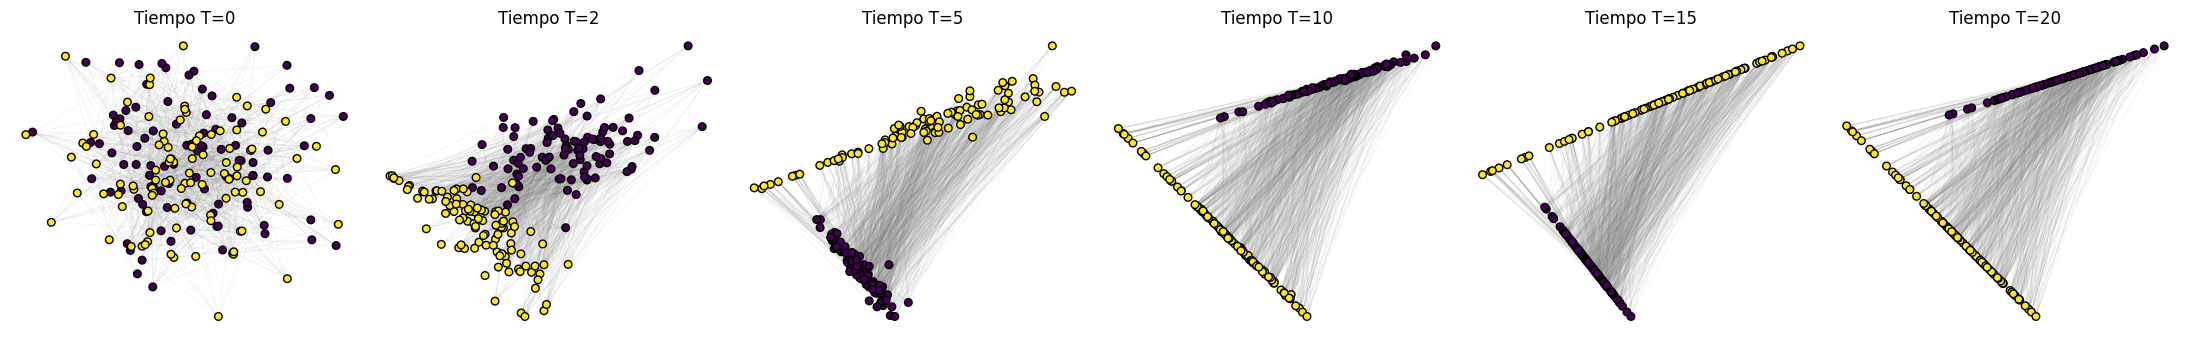

In [78]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

n_parts_test = 2
n_per_part_test = 100
seed_test = 0

# 1. Generar datos de TEST
G_test, edges_test, labels_test = make_n_partite_graph(n_parts=n_parts_test, n_per_part=n_per_part_test, p_edge=0.1, seed=seed_test)
X_test = make_gaussian_features(labels_test, mu=1.0, sigma=1.0, seed=seed_test)

X_test_torch = torch.from_numpy(X_test.astype(np.float32))
edges_test_torch = torch.from_numpy(edges_test)

# 2. Obtener la trayectoria usando el modelo entrenado
trajectory = gen_model.get_diffusion_trajectory(X_test_torch, edges_test_torch)

# 3. Visualizar CON ARISTAS para varios tiempos
times = [0, 2, 5, 10, 15, gen_model.T]
fig, axes = plt.subplots(1, len(times), figsize=(22, 3.5))

for i, t in enumerate(times):
    if t < len(trajectory):
        X_t = trajectory[t]
        ax = axes[i]
        
        start_points = X_t[edges_test[:, 0]]
        end_points   = X_t[edges_test[:, 1]]
        segments = np.stack((start_points, end_points), axis=1) 
        lc = LineCollection(segments, colors='gray', alpha=0.1, linewidths=0.5, zorder=1)
        ax.add_collection(lc)
        
        ax.scatter(X_t[:, 0], X_t[:, 1], c=labels_test, cmap='viridis', s=30, edgecolors='k', alpha=1.0, zorder=2)
        
        ax.set_title(f"Tiempo T={t}")
        ax.set_xticks([]); ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)

plt.tight_layout()
plt.show()


[PyG-GCN] Epoch 050 | loss=0.7268 | train=0.769 | test=0.750
[PyG-GCN] Epoch 100 | loss=0.6347 | train=0.706 | test=0.700
[PyG-GCN] Epoch 150 | loss=0.6199 | train=0.656 | test=0.675
[PyG-GCN] Epoch 200 | loss=0.6564 | train=0.669 | test=0.725
[PyG-GCN] Epoch 250 | loss=0.6350 | train=0.681 | test=0.725
[PyG-GCN] Epoch 300 | loss=0.6186 | train=0.675 | test=0.675
[PyG-GCN] Epoch 350 | loss=0.5981 | train=0.700 | test=0.725
[PyG-GCN] Epoch 400 | loss=0.6119 | train=0.694 | test=0.700
[PyG-GCN] Epoch 450 | loss=0.5734 | train=0.694 | test=0.800
[PyG-GCN] Epoch 500 | loss=0.5679 | train=0.675 | test=0.725


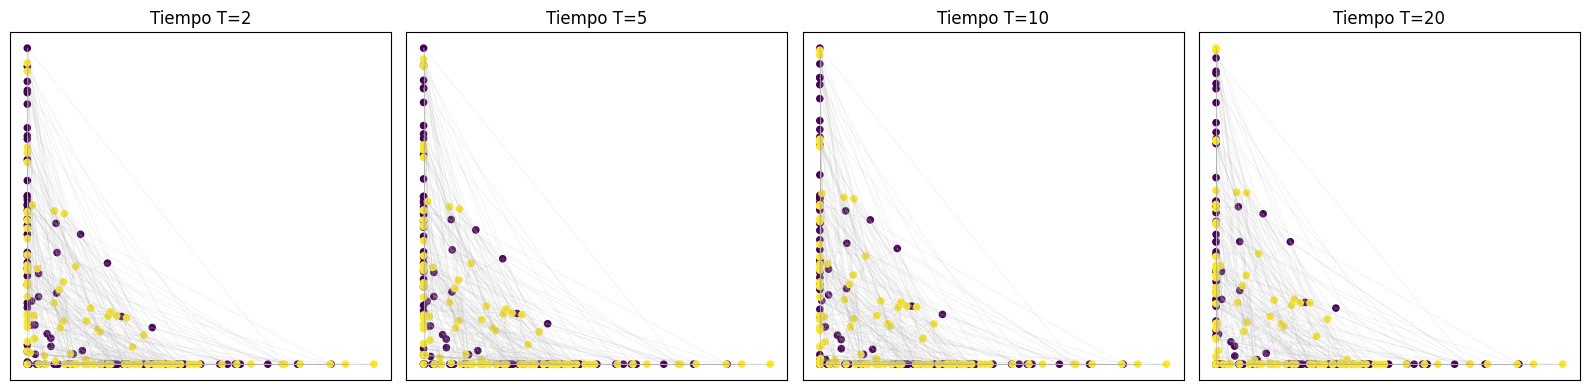

In [77]:
# ===========================================
# IMPORTS
# ===========================================
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt


# ===========================================
# MODELO GCN
# ===========================================
class GCN_PYG(torch.nn.Module):
    def __init__(self, in_dim=2, hidden=2, num_classes=2):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden)
        self.conv2 = GCNConv(hidden, num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=0.3, training=self.training)
        h = self.conv2(h, edge_index)
        return h


# ===========================================
# ENTRENAMIENTO + CAPTURA DE SNAPSHOTS
# ===========================================
def train_gcn_pyg_with_snapshots(
    data, train_idx, test_idx,
    epochs=400,
    snapshot_epochs=[0, 2, 5, 10, 20]
):
    model = GCN_PYG(in_dim=data.x.shape[1], hidden=2, num_classes=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=5e-4)

    snapshots = {}

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[train_idx], data.y[train_idx])
        loss.backward()
        optimizer.step()

        if epoch in snapshot_epochs:
            model.eval()
            with torch.no_grad():
                h1 = model.conv1(data.x, data.edge_index)
                h1 = F.relu(h1)
                snapshots[epoch] = h1.cpu().numpy()

        if (epoch + 1) % 50 == 0:
            model.eval()
            with torch.no_grad():
                pred = out.argmax(dim=1)
                train_acc = (pred[train_idx] == data.y[train_idx]).float().mean().item()
                test_acc  = (pred[test_idx]  == data.y[test_idx]).float().mean().item()
            print(f"[PyG-GCN] Epoch {epoch+1:03d} | loss={loss.item():.4f} "
                  f"| train={train_acc:.3f} | test={test_acc:.3f}")

    return model, snapshots


# ===========================================
# VISUALIZACIÓN DE LA EVOLUCIÓN DEL GRAFO
# ===========================================
def visualize_evolution(snapshots, edges, labels):
    nplots = len(snapshots)
    fig, axes = plt.subplots(1, nplots, figsize=(4 * nplots, 4))

    if nplots == 1:
        axes = [axes]

    for ax, (epoch, emb) in zip(axes, snapshots.items()):
        # nodos
        sc = ax.scatter(emb[:, 0], emb[:, 1], c=labels, cmap="viridis", s=20)

        # edges
        for i, j in edges:
            ax.plot(
                [emb[i, 0], emb[j, 0]],
                [emb[i, 1], emb[j, 1]],
                color=(0.7, 0.7, 0.7, 0.2),
                linewidth=0.5
            )

        ax.set_title(f"Tiempo T={epoch}", fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()


# ===========================================
# EJEMPLO DE USO COMPLETO
# ==========================================º

edge_index = edges_torch.t().contiguous()

data = Data(
    x=X0.float(),
    edge_index=edge_index,
    y=y.long()
)

snapshot_epochs = [2, 5, 10, 20]  

model, snapshots = train_gcn_pyg_with_snapshots(
    data,
    train_idx,
    test_idx,
    epochs=500,
    snapshot_epochs=snapshot_epochs
)

visualize_evolution(snapshots, edges, labels)
